In [1]:
# # This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')

# # TODO: Enter the foldername in your Drive where you have saved the unzipped
# # assignment folder, e.g. 'cs231n/assignments/assignment1/'
# FOLDERNAME = 'cs231n/assignments/assignment1/'
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# # Now that we've mounted your Drive, this ensures that
# # the Python interpreter of the Colab VM can load
# # python files from within it.
# import sys
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# # This downloads the CIFAR-10 dataset to your Drive
# # if it doesn't already exist.
# %cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
# !bash get_datasets.sh
# %cd /content/drive/My\ Drive/$FOLDERNAME

# --- CS231n local bootstrap (Linux/VSCode) ---
import os, sys
from pathlib import Path

ROOT = Path.cwd()           
CS231N_DIR = ROOT / "cs231n"
DATA_DIR   = CS231N_DIR / "datasets"

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

print(f"[info] ROOT={ROOT}")
print(f"[info] DATA_DIR={DATA_DIR}")

ok = (DATA_DIR / "cifar-10-batches-py").exists()
assert ok, "CIFAR-10 does not exist. Please run get_datasets.sh from cs231n/datasets."

[info] ROOT=/home/kim1484/cs231n/assignments/assignment1
[info] DATA_DIR=/home/kim1484/cs231n/assignments/assignment1/cs231n/datasets


# Softmax Classifier exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the Softmax classifier.
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
# # Run some setup code for this notebook.
# import random
# import numpy as np
# from cs231n.data_utils import load_CIFAR10
# import matplotlib.pyplot as plt

# # This is a bit of magic to make matplotlib figures appear inline in the
# # notebook rather than in a new window.
# %matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

# # Some more magic so that the notebook will reload external python modules;
# # see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload
# %autoreload 2

# --- Setup for CS231n Notebooks (VSCode / Linux Jupyter) ---
import random
import numpy as np
import matplotlib.pyplot as plt
from cs231n.data_utils import load_CIFAR10

try:
    get_ipython().run_line_magic("matplotlib", "inline")
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")
except Exception:
    pass

plt.rcParams["figure.figsize"] = (10.0, 8.0)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

print("[ready] Visualization & autoreload settings complete.")


[ready] Visualization & autoreload settings complete.


## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


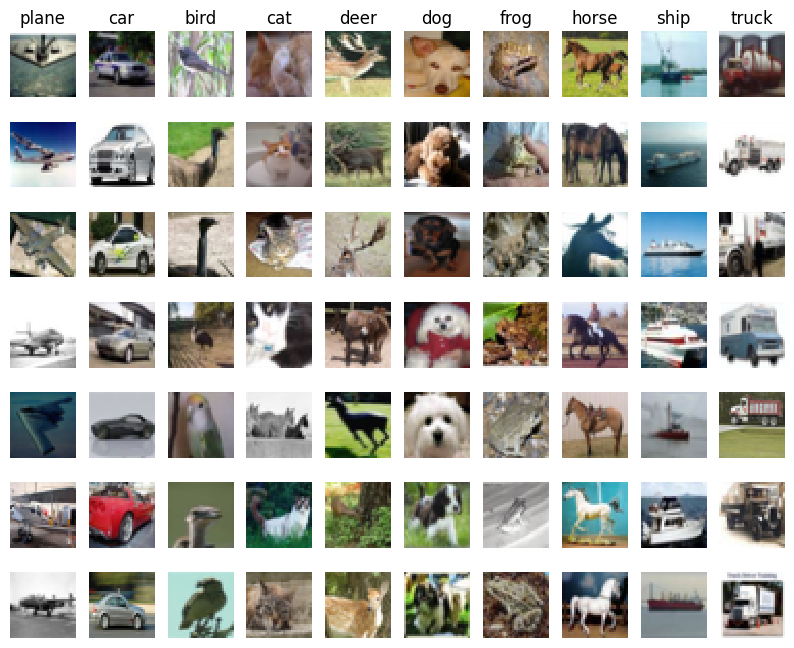

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


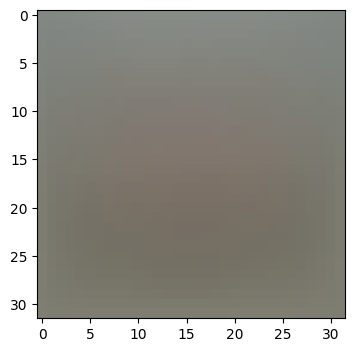

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.

As you can see, we have prefilled the function `softmax_loss_naive` which uses for loops to evaluate the softmax loss function.

In [8]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.softmax import softmax_loss_naive
import time

# generate a random Softmax classifier weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.369748
loss: 2.369748
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Since there are 10 classes, a random prediction would give each class a probability of 1/10, which is 0.1.*



The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the softmax loss function and implement it inline inside the function `softmax_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [9]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -0.130847 analytic: -0.130847, relative error: 5.462001e-08
numerical: -4.643492 analytic: -4.643492, relative error: 6.319417e-09
numerical: -1.782656 analytic: -1.782656, relative error: 2.546422e-09
numerical: -2.189420 analytic: -2.189420, relative error: 9.299752e-09
numerical: -4.416538 analytic: -4.416538, relative error: 9.847542e-09
numerical: -0.001590 analytic: -0.001590, relative error: 1.342641e-05
numerical: -0.309667 analytic: -0.309667, relative error: 9.219667e-08
numerical: -1.748485 analytic: -1.748486, relative error: 1.494725e-08
numerical: -2.291690 analytic: -2.291690, relative error: 1.608097e-08
numerical: -2.070834 analytic: -2.070834, relative error: 1.357907e-08
numerical: 0.846120 analytic: 0.846120, relative error: 3.074476e-08
numerical: -0.131508 analytic: -0.131508, relative error: 3.573007e-07
numerical: -4.675198 analytic: -4.675198, relative error: 7.859762e-09
numerical: 1.080730 analytic: 1.080730, relative error: 2.566046e-08
numerical:

**Inline Question 2**

Although gradcheck is reliable softmax loss, it is possible that for SVM loss, once in a while, a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a svm loss gradient check could fail? How would change the margin affect of the frequency of this happening?

Note that SVM loss for a sample $(x_i, y_i)$ is defined as: $$L_i = \sum_{j\ne y_i}\max(0, s_j - s_{y_i} + \Delta)$$ where $j$ iterates over all classes except the correct class $y_i$ and $s_j$ denotes the classifier score for $j^{th}$ class. $\Delta$ is a scalar margin. For more information, refer to 'Multiclass Support Vector Machine loss' on [this](https://cs231n.github.io/linear-classify/) page.

*Hint: the SVM loss function is not strictly speaking differentiable.*


$\color{blue}{\textit Your Answer:}$ *SVM loss have a nondifferentiable points. When $s_j - s_{y_i} + margin = 0$ the gradient is not uniquely defined. Because of this, numerical gradient checking can occasionally fail. During numerical differentiation using $\frac{f(x+h) - f(x-h)}{2h}$ the two evaluations may fall on different sides of the hinge:*
- *$(x + h)$ : analytic gradient = 1*  
- *$(x - h)$ : analytic gradient = 0*  

*Then the numerical gradient will be $\frac{1 - 0}{2}=0.5$, which differs from the analytic gradient.*

*So, a simple 1D example is $L(z) = max(0, z)$ where gradient checking will fail near (z = 0) as written above.*  

In [10]:
# Next implement the function softmax_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, _ = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 2.369748e+00 computed in 0.092785s
Vectorized loss: 2.369748e+00 computed in 0.003690s
difference: -0.000000


In [11]:
# Complete the implementation of softmax_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.113863s
Vectorized loss and gradient: computed in 0.004634s
difference: 743.281614


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [12]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 763.154791


iteration 100 / 1500: loss 275.154475
iteration 200 / 1500: loss 101.369540
iteration 300 / 1500: loss 38.310004
iteration 400 / 1500: loss 15.385269
iteration 500 / 1500: loss 7.056125
iteration 600 / 1500: loss 4.038732
iteration 700 / 1500: loss 2.931945
iteration 800 / 1500: loss 2.581013
iteration 900 / 1500: loss 2.436530
iteration 1000 / 1500: loss 2.390939
iteration 1100 / 1500: loss 2.357824
iteration 1200 / 1500: loss 2.368292
iteration 1300 / 1500: loss 2.367649
iteration 1400 / 1500: loss 2.357817
That took 11.285066s


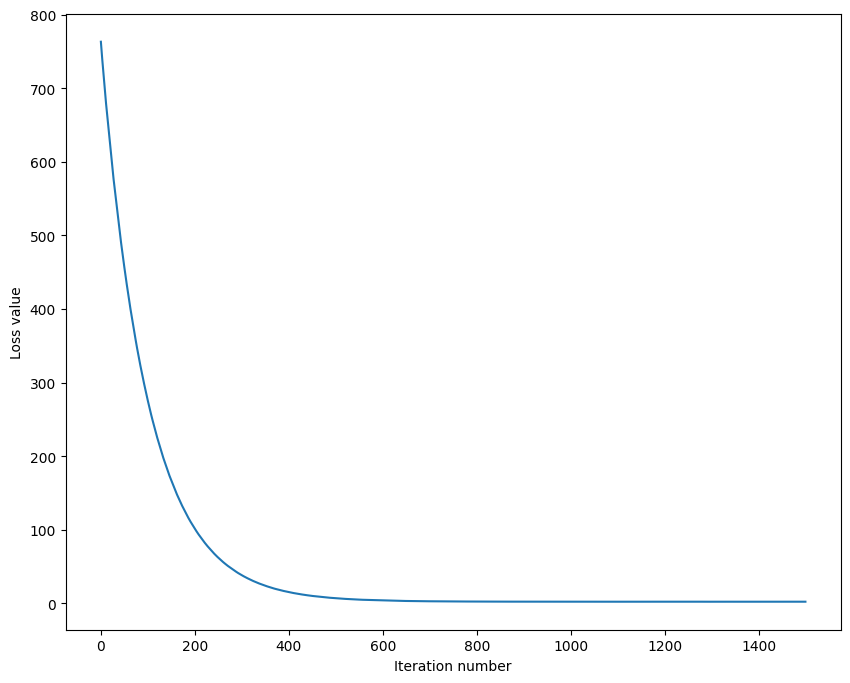

In [13]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [14]:
# Write the LinearClassifier.predict function and evaluate the performance on
# both the training and validation set
# You should get validation accuracy of about 0.34 (> 0.33).
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.384816
validation accuracy: 0.386000


In [15]:
# Save the trained model for autograder.
softmax.save("softmax.npy")

softmax.npy saved.


In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.365 (> 0.36) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search.
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_softmax = None # The Softmax object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a Softmax on the.        #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the Softmax object that achieves this.   #
# accuracy in best_softmax.                                                    #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the classifiers don't take much time to train; once  #
# you are confident that your validation code works, you should rerun the      #
# code with a larger value for num_iters.                                      #
learning_rates = [1e-7, 1e-6]
regularization_strengths = [2.5e4, 1e4]

for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=reg, 
                      num_iters=1000, verbose=False)
        # y_train_pred = softmax.predict(X_train)
        # y_val_pred = softmax.predict(X_val)
        y_train_pred, y_val_pred = softmax.predict(X_train), softmax.predict(X_val)
        
        # train_accuracy = np.mean(y_train == y_train_pred)
        # val_accuracy = np.mean(y_val_pred == y_val)
        # results[(lr, reg)] = (train_accuracy, val_accuracy)
        results[(lr, reg)] = np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred)

        # if val_accuracy > best_val:
        #     best_val = val_accuracy
        #     best_softmax = softmax
        if results[(lr, reg)][1] > best_val:
            best_val = results[(lr, reg)][1]
            best_softmax = softmax
################################################################################
# # Provided as a reference. You may or may not want to change these hyperparameters
# learning_rates = [1e-7, 1e-6]
# regularization_strengths = [2.5e4, 1e4]



# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

/home/kim1484/cs231n/assignments/assignment1/cs231n/classifiers/softmax.py:85: RuntimeWarning: divide by zero encountered in log
  loss -= np.sum(np.log(result))
/home/kim1484/cs231n/assignments/assignment1/cs231n/classifiers/softmax.py:86: RuntimeWarning: overflow encountered in scalar multiply
  loss = loss / num_train + reg * np.sum(W * W)
/home/kim1484/anaconda3/envs/cs231n/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/kim1484/cs231n/assignments/assignment1/cs231n/classifiers/softmax.py:86: RuntimeWarning: overflow encountered in multiply
  loss = loss / num_train + reg * np.sum(W * W)
/home/kim1484/cs231n/assignments/assignment1/cs231n/classifiers/softmax.py:79: RuntimeWarning: invalid value encountered in subtract
  scores -= np.reshape(np.max(scores, axis=1), (-1, 1))  # (500, 10)


lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.263592 val accuracy: 0.264000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.380776 val accuracy: 0.381000
lr 1.000000e-06 reg 1.000000e+04 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-06 reg 2.500000e+04 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.381000


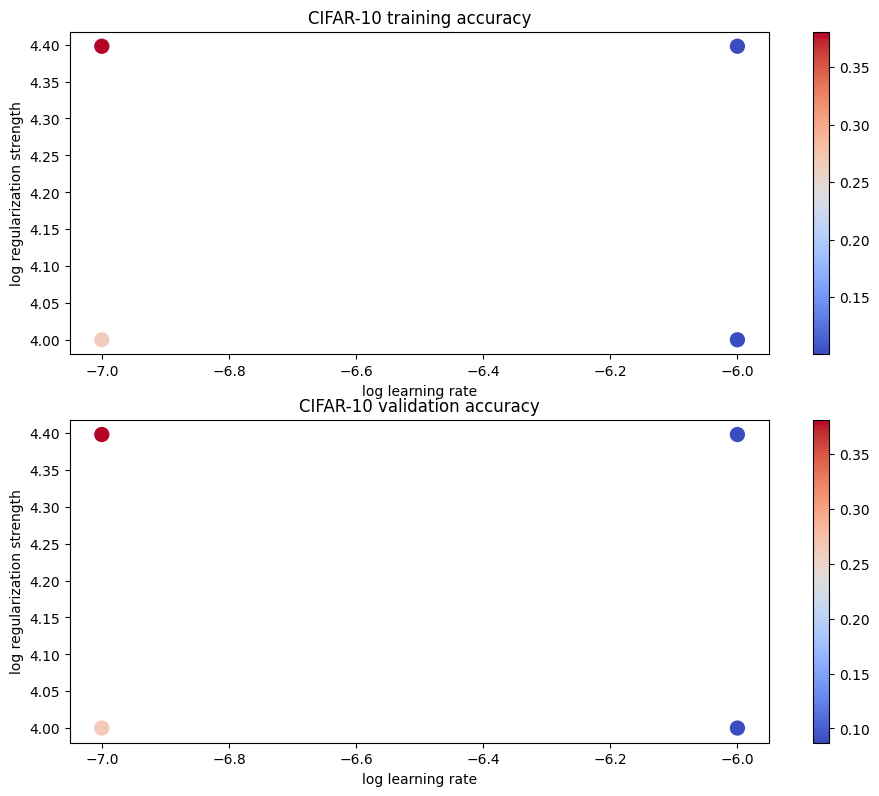

In [17]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [18]:
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Softmax classifier on raw pixels final test set accuracy: %f' % test_accuracy)

Softmax classifier on raw pixels final test set accuracy: 0.373000


In [19]:
# Save best softmax model
best_softmax.save("best_softmax.npy")

best_softmax.npy saved.


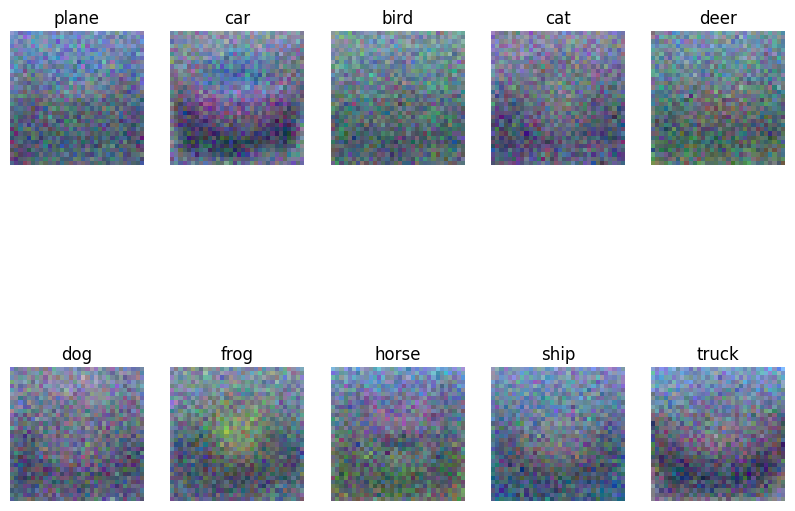

In [20]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 3**

Describe what your visualized Softmax classifier weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$ *The visualized Softmax weights appear as noisy and blurry color patterns rather than distinct shapes. This is because the softmax classifier is a linear model, it cannot learn complex spatial patterns or object structures. As a result, it only reflects the average color distribution or coarse shape tendency of each class (e.g. the car class)*  


**Inline Question 4** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would change the softmax loss, but leave the SVM loss unchanged.

$\color{blue}{\textit Your Answer:}$ Yes


$\color{blue}{\textit Your Explanation:}$ For the SVM loss, each term has the form $max(0, s_j - s_{y_i} + margin)$. If $(s_j - s_{y_i} + margin)$ is below 0 for all incorrect classes, the hinge loss for that datapoint becomes 0, so adding this datapoint does not change the total SVM loss.

